In [1]:
%matplotlib inline
# %matplotlib widget
import numpy as np
from matplotlib import pyplot as plt
import copy
import glob
from scipy import misc
import cv2
import os

In [33]:
default_config = {
    'reference': {
        'tau': 20.0, # frames
        'dec': np.exp(-1.0 / 40.0), # frames
        'dec_prob': 0.001
    },
    'threshold':{
        'tau': 10.0, # frames
        'dec': 1.,#np.exp(-1.0 / 5.0 ), # frames
        'increment': 1., # mult
        'base': 0.05, # v
    },
    'range':{
        'minimum': 0.0, # v
        'maximum': 1.0, # v
    },
    'spike_on_positive_dv': True,
}

def get_params(config):
    global default_config
    dc = default_config

    ref_dec = config.get('reference', dc['reference'])['dec']
    ref_dec_p = config.get('reference', dc['reference'])['dec_prob']
    thr_inc = config.get('threshold', dc['threshold'])['increment']
    thr_dec = config.get('threshold', dc['threshold'])['dec']
    thr0 = config.get('threshold', dc['threshold'])['base']
    vmin = config.get('range', dc['range'])['minimum']
    vmax = config.get('range', dc['range'])['maximum']
    
    return ref_dec, ref_dec_p, thr_inc, thr_dec, thr0, vmin, vmax
    
def nvs(val, ref, thr, config=default_config):
    if 'spike_on_positive_dv' in config:
        pos_dv = config['spike_on_positive_dv']
    else:
        pos_dv = True
    
    ref_dec, ref_dec_p, thr_inc, thr_dec, thr0, vmin, vmax = \
        get_params(config)
    
    ref0 = vmin if pos_dv else vmax
    
    dv = val - ref
    
    rd = ref_dec * np.ones_like(ref)
    no_decay = np.where(np.random.uniform(0., 1., size=ref.shape) > ref_dec_p)
    rd[no_decay] = 1
    ref = np.clip(ref0 + (ref - ref0) * rd, vmin, vmax)
        
    dvp = dv >= thr
    dvn = dv <= -thr
#     spiked = False
    spk = np.where(np.logical_or(dvp, dvn))
    thr[spk] *= thr_inc # scalar
    ref[spk] += dv[spk]
    if pos_dv:
        spiked = dvp * dv
    else:
        spiked = dvn * dv

    thr = np.clip(thr0 + (thr - thr0) * thr_dec, thr0, vmax)
    
    return ref, thr, spiked

def experiment(vin, cfg_p, cfg_n):
    v = np.asarray(vin)
    refp = np.array([0.0])
    thrp = np.array([0.05])
    refp_history = [refp]
    spike_p_t = []

    refn = np.array([1.0])
    thrn = np.array([0.05])
    refn_history = [refn]
    spike_n_t = []

    ref = (refp + refn) * 0.5 + np.random.uniform(-thrn, thrn)
    ref_history = [ref]
    for t, val in enumerate(v):

        refp, thrp, spike_p = nvs(val, refp, thrp, cfg_p)
        refn, thrn, spike_n = nvs(val, refn, thrn, cfg_n)

        if spike_p > 0.0:
            spike_p_t.append(t)

        elif spike_n < 0.0:
            spike_n_t.append(t)

        refp_history.append(refp)
        refn_history.append(refn)

        ref_history.append( (refp + refn) * 0.5 )

    data = dict(
        spike_p_t = np.asarray(spike_p_t),
        spike_n_t = np.asarray(spike_n_t),
        ref_history = np.asarray(ref_history),
        refp_history = np.asarray(refp_history),
        refn_history = np.asarray(refn_history),
    )

    return data


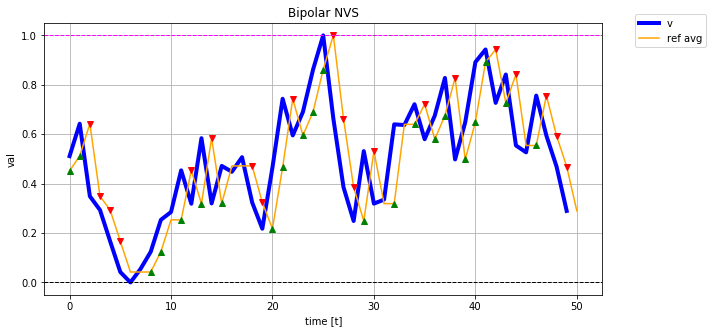

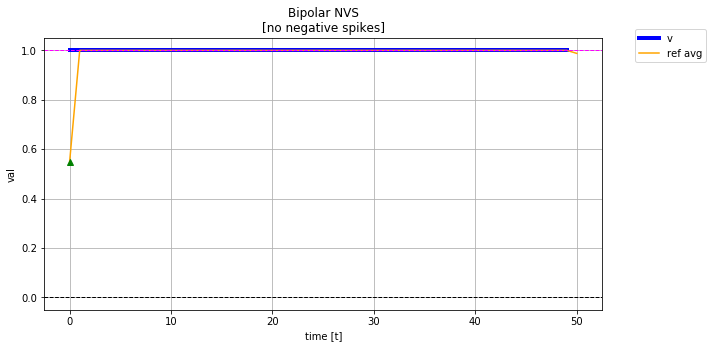

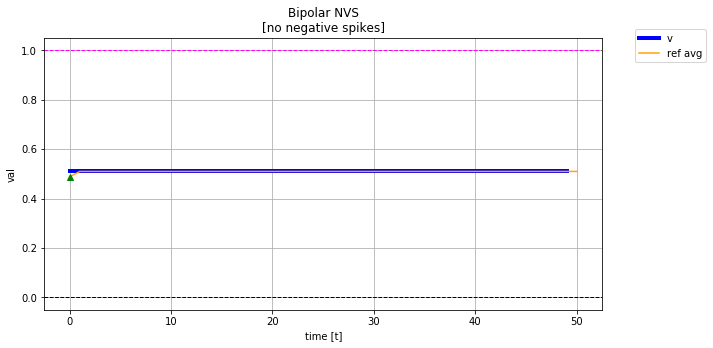

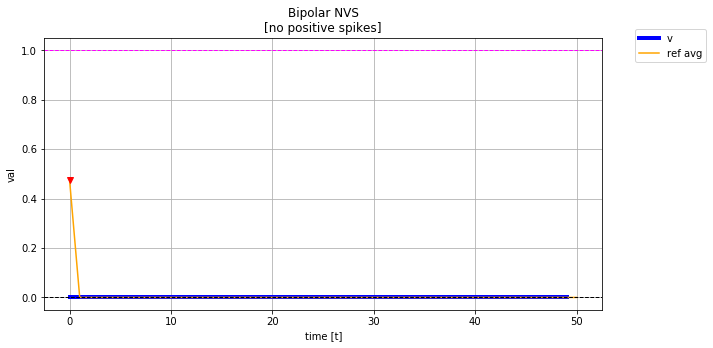

In [34]:
colors = [
    'red',
    'green',
    'blue',
    'orange',
    'gray',
    'magenta',
    'cyan',
]
seed = 1
n_samples = 50
np.random.seed(seed)
# v = np.random.uniform(0., 1., size=n_samples)
vv = np.random.uniform(-1., 1., size=n_samples)
for t in range(1, n_samples):
    vv[t] = vv[t-1] * 0.75 + vv[t]
vv -= vv.min()
vv *= 1./vv.max()

vs = [
    vv, 
    1.0 * np.ones(n_samples),
    0.51 * np.ones(n_samples),
    np.zeros(n_samples),
]


cfg_p = copy.copy(default_config)
cfg_n = copy.copy(default_config)
cfg_n['spike_on_positive_dv'] = False

for v in vs:
    d = experiment(v, cfg_p, cfg_n)
    ref_history = d['ref_history']
    spike_p_t = d['spike_p_t']
    spike_n_t = d['spike_n_t']

    fw = 5
    plt.figure(figsize=(2.0 * fw, fw))
    ax = plt.subplot(1, 1, 1)
    
    title = 'Bipolar NVS'

    plt.plot(v, label='v', color=colors[2], linewidth=4)

    plt.plot(ref_history[0:], '-', label='ref avg', color=colors[3])
    try:
        plt.plot(spike_p_t, ref_history[spike_p_t], linestyle='none', marker='^', color='green')
    except:
        title += '\n[no positive spikes]'
    try:
        plt.plot(spike_n_t, ref_history[spike_n_t], linestyle='none', marker='v', color='red')
    except:
        title += '\n[no negative spikes]'

    ax.set_title(title)
    ax.set_xlabel('time [t]')
    ax.set_ylabel('val')
    plt.axhline(1, linestyle='--', color='magenta', linewidth=1)
    plt.axhline(0, linestyle='--', color='black', linewidth=1)
    plt.legend(bbox_to_anchor=(1.05, 1.05))
    plt.grid()
    plt.show()

['./white_circle.png', './white_triangle.png']


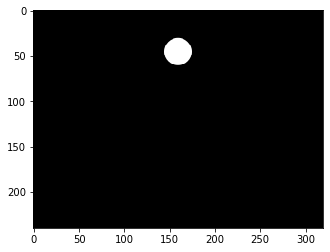

In [47]:
ARED, ABLUE = 0.299, 0.114
AGREEN = 1.0 - ARED - ABLUE

image_files = sorted( glob.glob('./*.png') )
print(image_files)
img = cv2.cvtColor( cv2.imread(image_files[0]), cv2.COLOR_BGR2RGB ).astype('float')
img *= 1./255.0
img = ARED * img[:, :, 0] + AGREEN * img[:, :, 1] + ABLUE * img[:, :, 2]

# img = misc.face(gray=True).astype('float')
# img *= 1./255.0

plt.figure()
plt.imshow(img, cmap='gray', vmin=0, vmax=1)
plt.show()

speed = 0.06


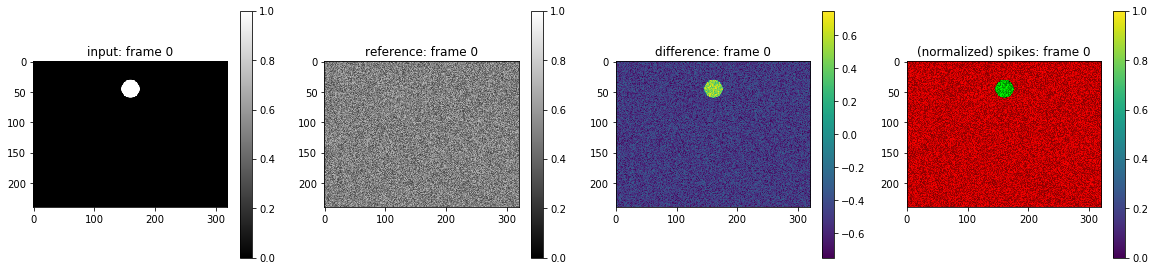

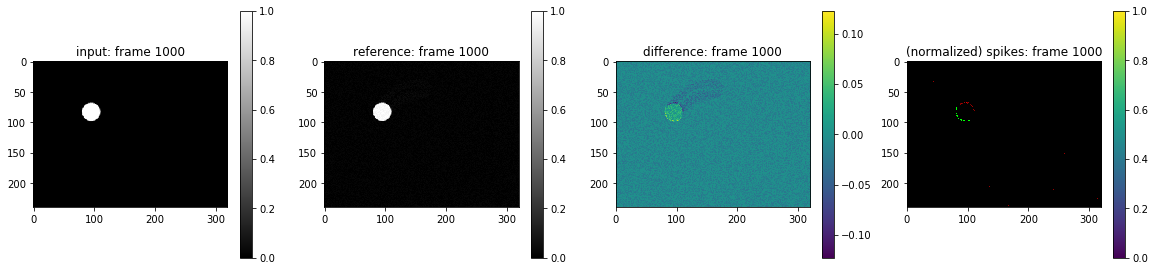

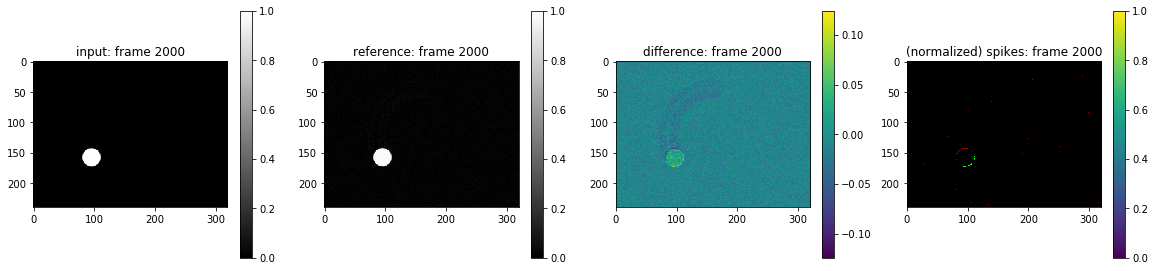

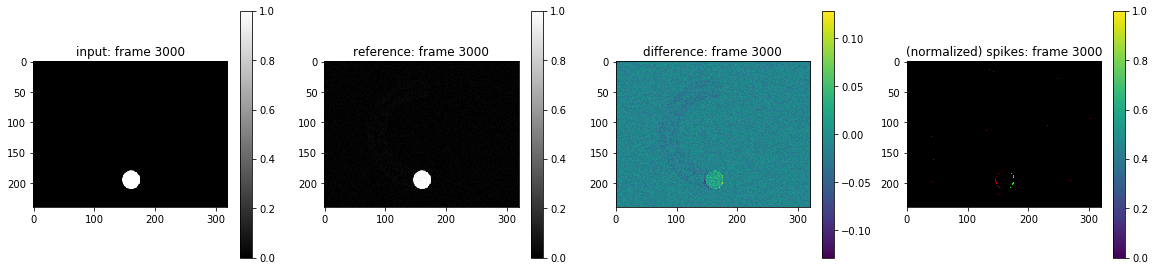

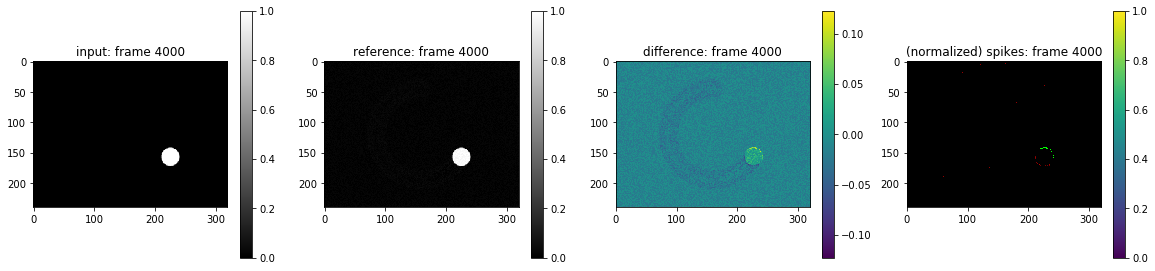

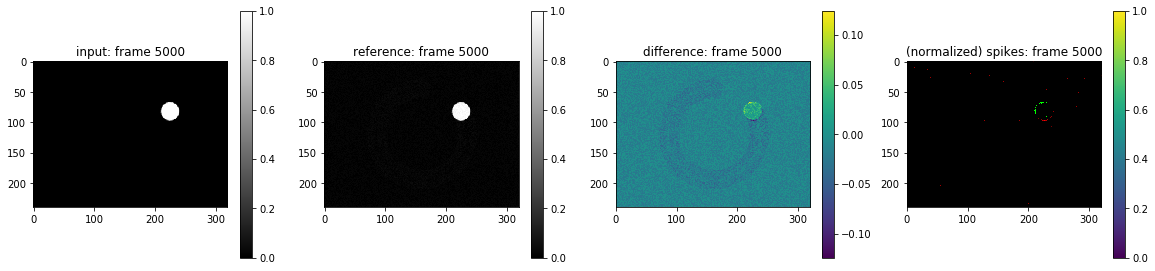

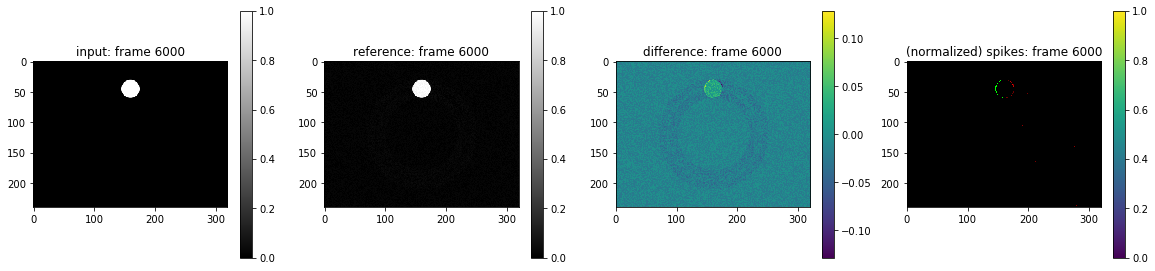

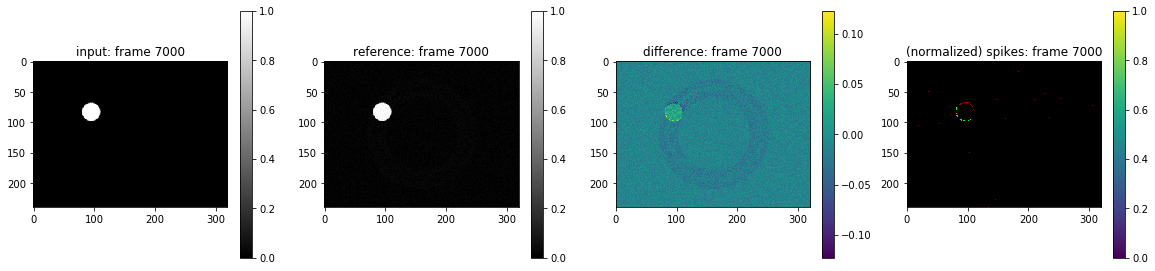

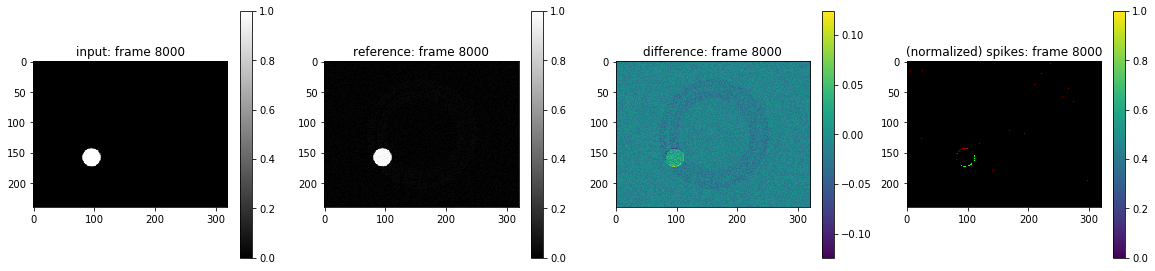

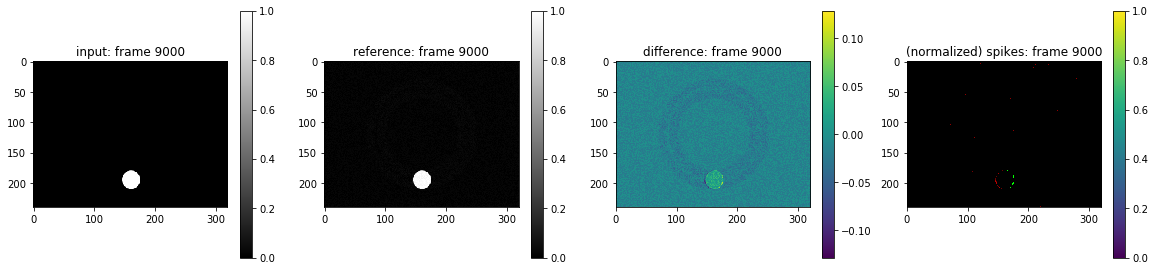

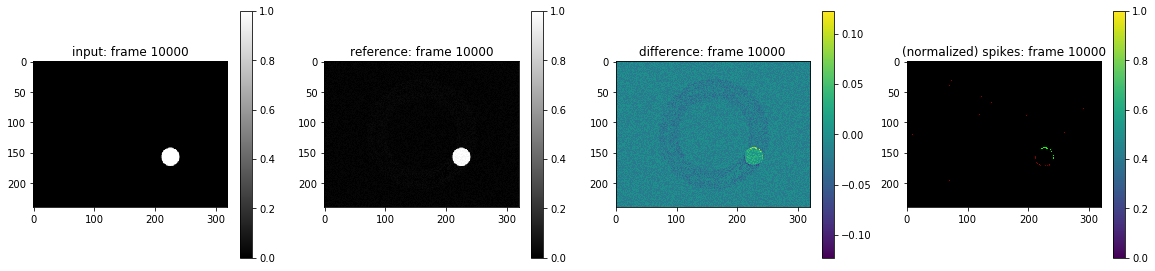

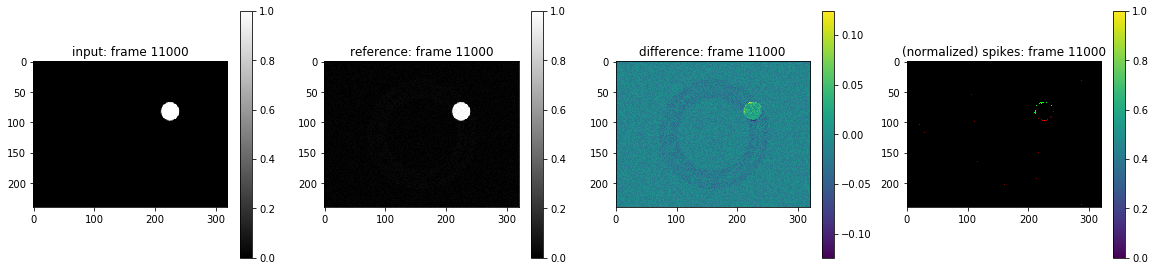

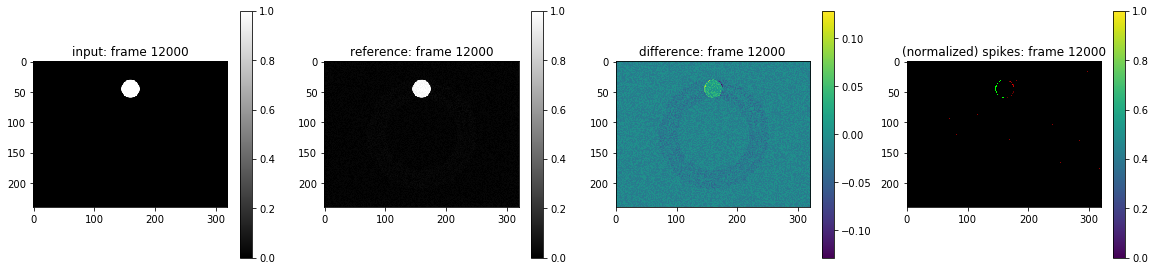

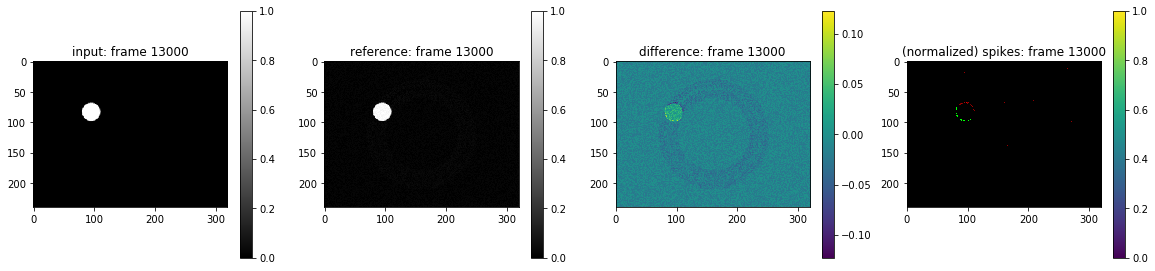

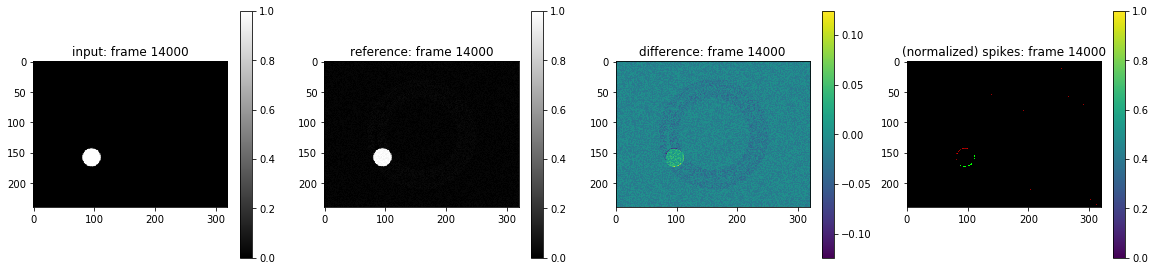

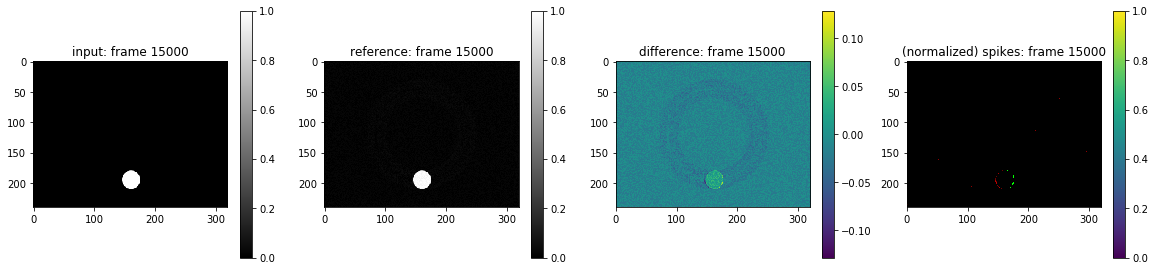

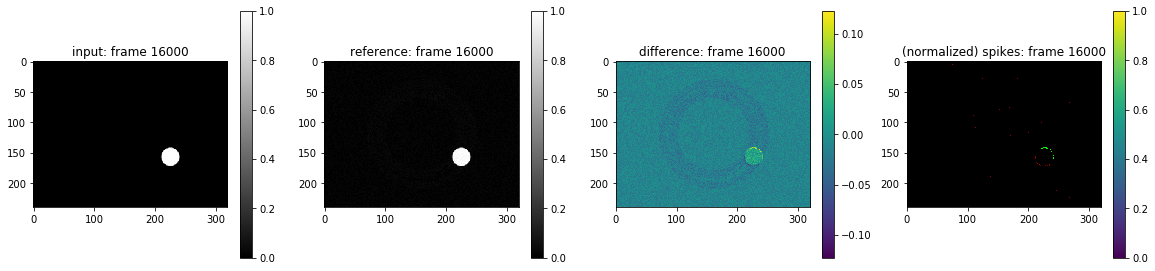

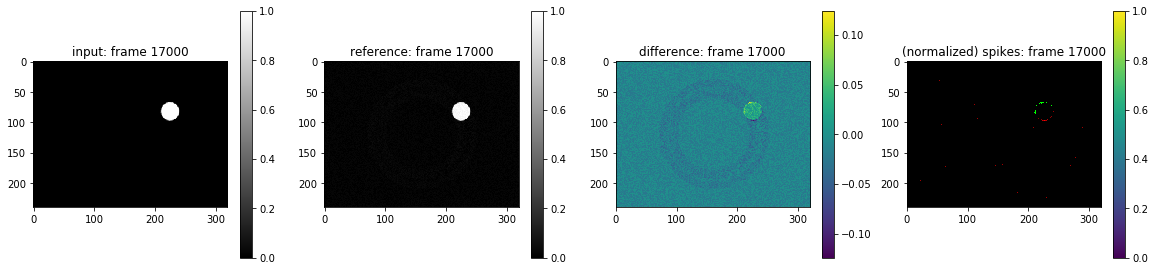

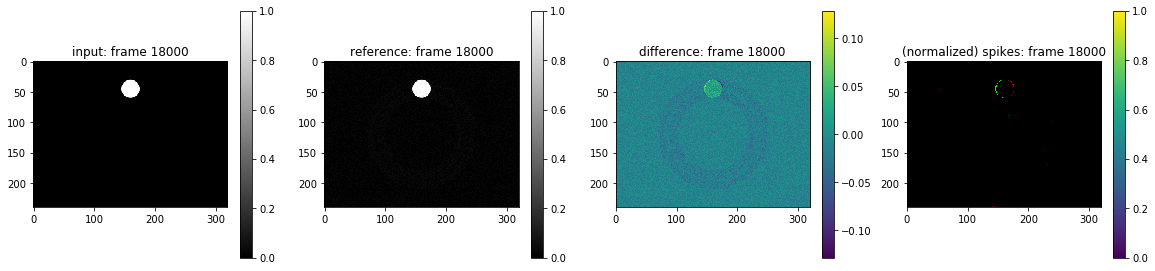

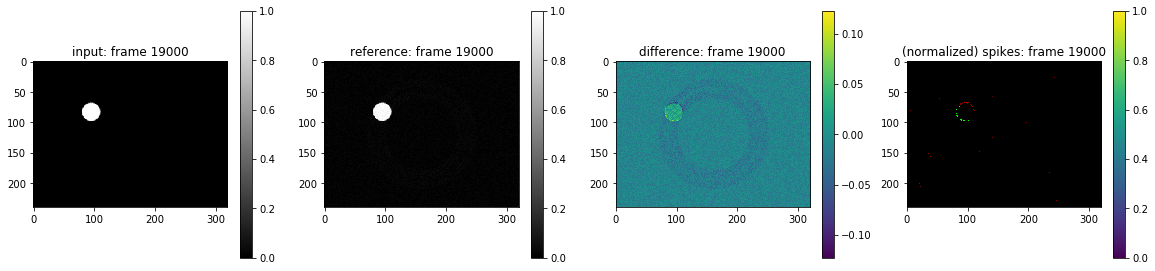

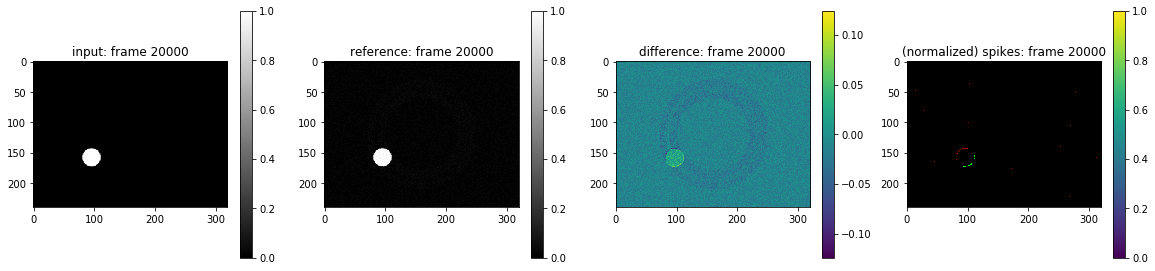

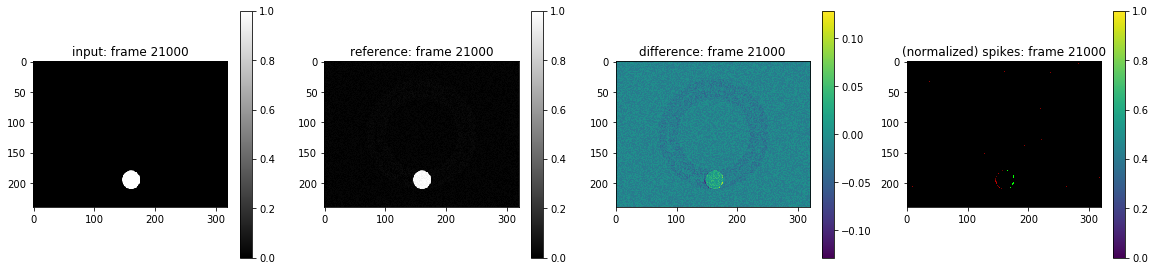

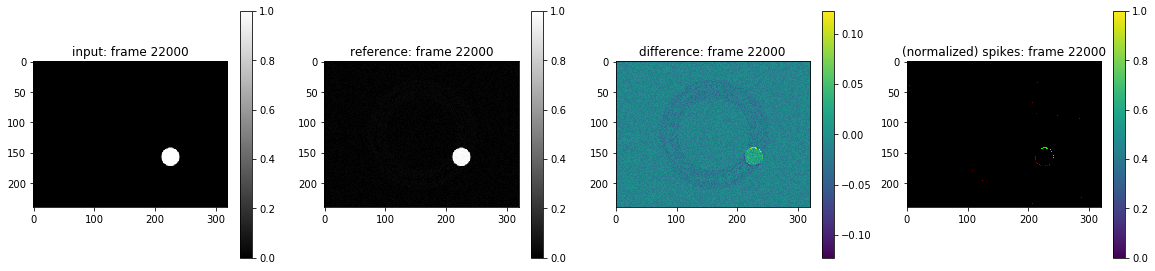

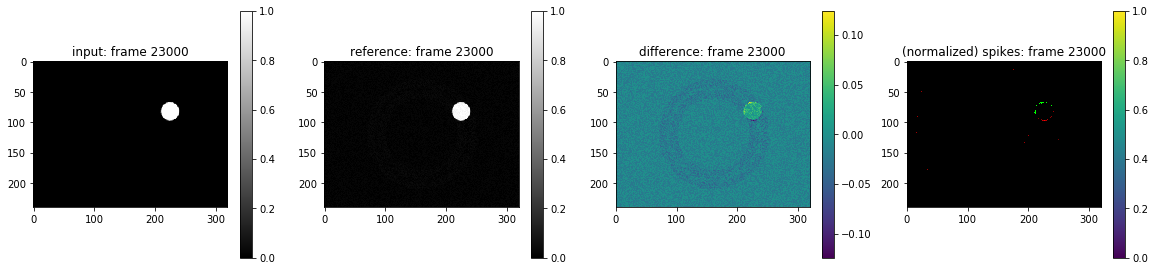

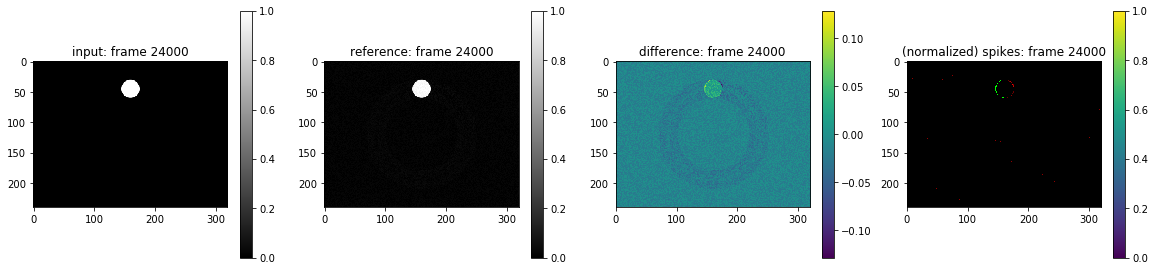

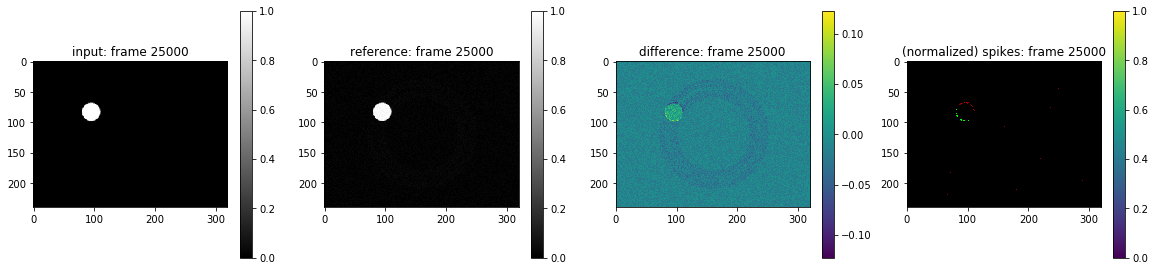

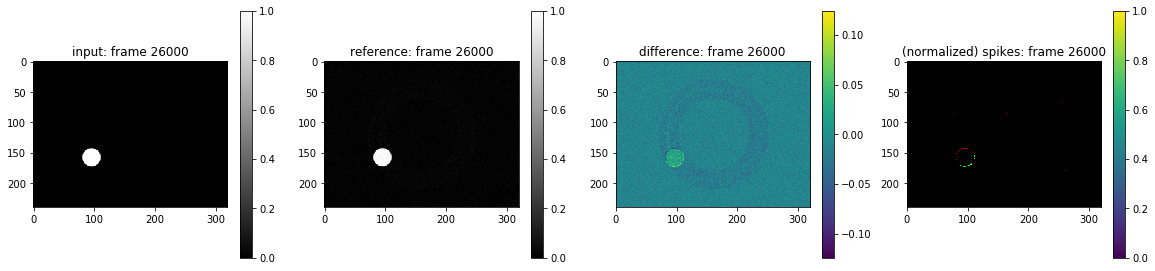

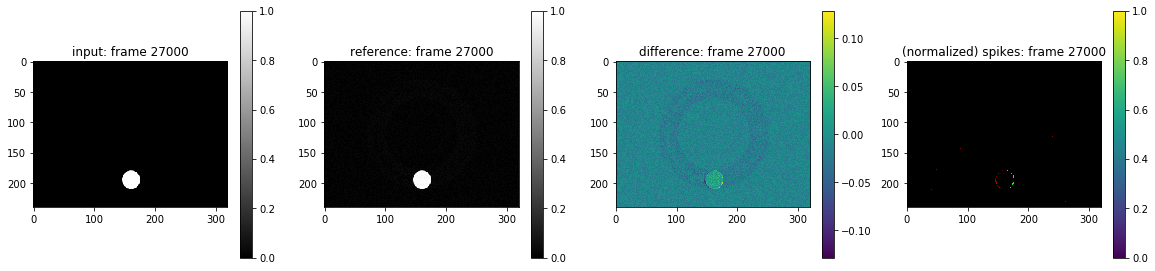

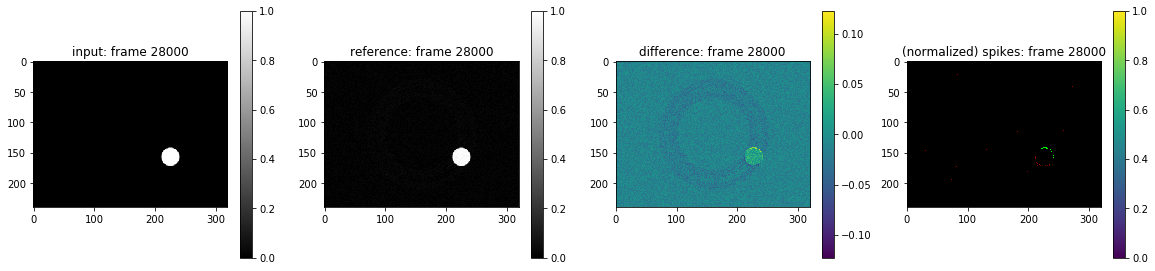

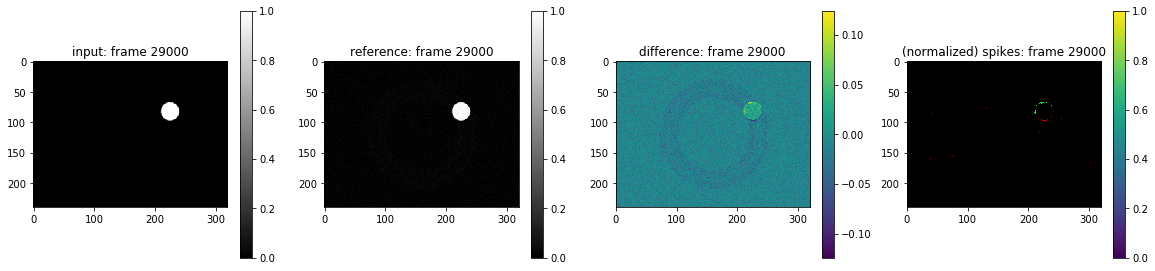

In [48]:
def get_range_tgt(dx, size):
    return max(0, dx), min(size + dx, size)

def get_range_src(dx, size):
    return max(0, -dx), min(size - dx, size)

def rotate_image(image, angle):
    on = np.where(image > 0)
#     image_center = (int(np.mean(on[0])), int(np.mean(on[1])))
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

ON = '1'
OFF = '0'

cwd = os.getcwd()
out_dir = os.path.join(cwd, "simulation")
os.makedirs(out_dir, exist_ok=True)
spk_out = os.path.join(out_dir, "spikes.txt")
try:
    os.remove(spk_out)
except:
    print(f"file {spk_out} not found")

prv = img.copy()
src = img.copy()
diff = np.zeros_like(img)
ref = np.zeros_like(img)
refp = np.random.uniform(0., 0.5, size=img.shape)
# refp = np.zeros_like(img)
thrp = 0.05 * np.zeros_like(img)
refn = np.random.uniform(0.5, 1., size=img.shape)
# refn = np.ones_like(img)
thrn = 0.05 * np.zeros_like(img)
cfg_p = copy.copy(default_config)
cfg_n = copy.copy(default_config)
cfg_n['spike_on_positive_dv'] = False

rows, cols = src.shape
spikes = np.zeros((rows, cols, 3))

fig_r = 2
fig_c = 4
fw = 5.0
static = bool(1)
shake_t = 2
n_rot_per_min = 10.
deg_per_rot = 360.
s_in_min = 60.
ms_in_s = 1000.
n_min = 0.50
n_samples = int(np.ceil(n_min * s_in_min * ms_in_s))
rot_speed = n_rot_per_min * deg_per_rot / (s_in_min * ms_in_s) # deg / ms(frame)
print(f"speed = {rot_speed}")
frame_count = 0
for t in range(n_samples):

    if not static and (t%shake_t) == 0:
        [dr, dc] = np.random.uniform(-1., 1., size=2) * 2.0
        print(dr, dc)
        T = np.float32([[1, 0, dc], [0, 1, dr]]) 
        src[:] = 0
        src[:] = cv2.warpAffine(img, T, (cols, rows))
    if rot_speed != 0:
        src[:] = rotate_image(img, t * rot_speed)
    
    img_name = os.path.join(out_dir, f"image_t_{t:06d}.png")
    cv2.imwrite(img_name, (src * 255).astype('uint8'))

    ref[:] = (refp + refn) * 0.5
    diff[:] = src - ref
    
    refp[:], thrp[:], spike_p = nvs(src, refp, thrp, config=cfg_p)
    refn[:], thrn[:], spike_n = nvs(src, refn, thrn, config=cfg_n)

#     spikes[:, :, 0] = src
#     spikes[:, :, 1] = src
#     spikes[:, :, 2] = src
    spikes[:] = 0

    wp = np.where(np.logical_and(spike_p > 0, spike_p > -spike_n))
    with open(spk_out, 'a') as spks_f:
        spks_f.write("\n".join([f"{r}, {c}, {ON}, {t}, {spike_p[r,c]}" for r, c in zip(*wp)]))
        spks_f.write("\n")

    maxp = np.max(spike_p[wp]) if len(wp[0]) else 0
    n_spike_p = spike_p if maxp <= 0. else spike_p / maxp
    spikes[wp[0], wp[1], 0] = 0
    spikes[wp[0], wp[1], 1] = 0
    spikes[wp[0], wp[1], 2] = 0
    spikes[wp[0], wp[1], 1] = np.clip(n_spike_p[wp]/maxp, 0., 1.)

    wn = np.where(np.logical_and(spike_n < 0, spike_p < -spike_n))
    with open(spk_out, 'a') as spks_f:
        spks_f.write("\n".join([f"{r}, {c}, {OFF}, {t}, {-spike_n[r,c]}" for r, c in zip(*wn)]))
        spks_f.write("\n")

    maxn = np.max(-spike_n[wn]) if len(wn[0]) else 0
    n_spike_n = spike_n if maxn <= 0. else spike_n / maxn
    spikes[wn[0], wn[1], 0] = 0
    spikes[wn[0], wn[1], 1] = 0
    spikes[wn[0], wn[1], 2] = 0
    spikes[wn[0], wn[1], 0] = np.clip(-n_spike_n[wn], 0., 1.)

    if t % 1000 == 0:
        fig = plt.figure(figsize=(fig_c * fw,  fig_r * fw))

        base = 0#t * fig_c
        ax = plt.subplot(fig_r, fig_c, base + 1)
        ax.set_title('input: frame %d'%t)
        im = plt.imshow(src, cmap='gray', vmin=0, vmax=1)
        plt.colorbar(im)

        ax = plt.subplot(fig_r, fig_c, base + 2)
        ax.set_title('reference: frame %d'%t)
        im = plt.imshow(ref, cmap='gray', vmin=0, vmax=1)
        plt.colorbar(im)

        ax = plt.subplot(fig_r, fig_c, base + 3)
        ax.set_title('difference: frame %d'%t)
        vmax = np.abs(diff).max()
        im = plt.imshow(diff, vmin=-vmax, vmax=vmax)
        plt.colorbar(im)

        ax = plt.subplot(fig_r, fig_c, base + 4)
        ax.set_title('(normalized) spikes: frame %d'%t)
        im = plt.imshow(spikes)
        plt.colorbar(im)

        plt.show()
        plt.close(fig)

In [49]:
cwd = os.getcwd()
out_dir = os.path.join(cwd, "simulation")
imgs = glob.glob(os.path.join(out_dir, "*.png"))
print(len(imgs))

30911


In [51]:
tmp_img = np.zeros((240, 320, 3), dtype='uint8')
with open(spk_out) as spk_f:
    write_out = False
    line_count = 0
    last_time = 0
    frame_count = 0
    while True:
        line = spk_f.readline()
        if line == "\n":
            continue
        if len(line) == 0:
            print(f"end of file? {len(line)}")
            break
#         print(line)
        srow, scol, spolarity, stime, sdv = line.split(', ')
        row = int(srow)
        col = int(scol)
        spike_time = int(stime)
        
        if line_count == 0:
            last_time = spike_time
        
        line_count += 1
        
        if last_time != spike_time:
            if last_time > 0 and last_time % 33 == 0:
                print(f"write image {last_time}")
                fname = os.path.join(out_dir, f"spike_image_{frame_count:06d}.png")
                print(fname)
                cv2.imwrite(fname, tmp_img)
                tmp_img[:] = 0
                frame_count += 1
        chan = 2 if spolarity == '0' else 1
        tmp_img[row, col, chan] = 255# min(tmp_img[row, col, chan] + 16, 255)
        
        last_time = spike_time
    
    print(f"write image {last_time}")
    fname = os.path.join(out_dir, f"spike_image_{last_time:06d}.png")
    cv2.imwrite(fname, tmp_img)
    tmp_img[:] = 0
    frame_count += 1
        

write image 33
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000000.png
write image 66
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000001.png
write image 99
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000002.png
write image 132
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000003.png
write image 165
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000004.png
write image 198
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000005.png
write image 231
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000006.png
write image 264
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000007.png
write image 297
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penul

write image 3927
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000118.png
write image 3960
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000119.png
write image 3993
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000120.png
write image 4026
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000121.png
write image 4059
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000122.png
write image 4092
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000123.png
write image 4125
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000124.png
write image 4158
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000125.png
write image 4191
/home/chanokin/sussex/spike_conv_nets/spike_con

write image 7590
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000229.png
write image 7623
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000230.png
write image 7656
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000231.png
write image 7689
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000232.png
write image 7722
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000233.png
write image 7755
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000234.png
write image 7788
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000235.png
write image 7821
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000236.png
write image 7854
/home/chanokin/sussex/spike_conv_nets/spike_con

write image 11187
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000338.png
write image 11220
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000339.png
write image 11253
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000340.png
write image 11286
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000341.png
write image 11319
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000342.png
write image 11352
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000343.png
write image 11385
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000344.png
write image 11418
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000345.png
write image 11451
/home/chanokin/sussex/spike_conv_nets/

write image 14817
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000448.png
write image 14850
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000449.png
write image 14883
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000450.png
write image 14916
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000451.png
write image 14949
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000452.png
write image 14982
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000453.png
write image 15015
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000454.png
write image 15048
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000455.png
write image 15081
/home/chanokin/sussex/spike_conv_nets/

write image 18348
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000555.png
write image 18381
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000556.png
write image 18414
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000557.png
write image 18447
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000558.png
write image 18480
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000559.png
write image 18513
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000560.png
write image 18546
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000561.png
write image 18579
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000562.png
write image 18612
/home/chanokin/sussex/spike_conv_nets/

write image 21879
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000662.png
write image 21912
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000663.png
write image 21945
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000664.png
write image 21978
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000665.png
write image 22011
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000666.png
write image 22044
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000667.png
write image 22077
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000668.png
write image 22110
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000669.png
write image 22143
/home/chanokin/sussex/spike_conv_nets/

write image 25443
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000770.png
write image 25476
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000771.png
write image 25509
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000772.png
write image 25542
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000773.png
write image 25575
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000774.png
write image 25608
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000775.png
write image 25641
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000776.png
write image 25674
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000777.png
write image 25707
/home/chanokin/sussex/spike_conv_nets/

write image 29007
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000878.png
write image 29040
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000879.png
write image 29073
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000880.png
write image 29106
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000881.png
write image 29139
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000882.png
write image 29172
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000883.png
write image 29205
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000884.png
write image 29238
/home/chanokin/sussex/spike_conv_nets/spike_conv_nets/penultimate/simulation/spike_image_000885.png
write image 29271
/home/chanokin/sussex/spike_conv_nets/